In [109]:
import re
import ast
import json
import pandas as pd
import matplotlib.pyplot as plt

# Functions

In [162]:
def load_data(filename):
    with open(filename, 'r') as file:
        for line in file:
            lines = line.split('}')
    upd_lines = []
    for line in lines:
        line += "}"
        upd_lines.append(line)
    new_dict = {}
    for line in upd_lines[:-1]:
        x = line.split(":", 1)
        new_dict[x[0]] = ast.literal_eval(x[1])
    return new_dict

def plot_time_series(metric, name):
    fig, ax = plt.subplots()
    plt.style.use('ggplot')
    for m, col in zip('xosdpHPD', metric):
        ax.plot(metric[col], label=metric[col].name, marker=m)
    #ax.plot(metric, label=metric.columns, marker='o')
    ax.set_axisbelow(True)
    ax.set_title(name)
    ax.set_xlabel("Duomenų kiekis")
    ax.set_ylabel("Vertė")
    ax.legend(bbox_to_anchor=(1.05, 1))
    plt.savefig(f"images/results/time_graphs/{name}")

# Multiclass classification

In [3]:
precision = {
    '1000':
    {
        'kNN': 0.6761972976624814,
        'LR': 0.6613308464604422,
        'RF': 0.8591613222338605,
        'XGBoost': 0.8992054763882544,
        'LightGBM': 0.895590617281605,
        'SVM': 0.73929521235472,
        'FF-NN': 0.7383014513532674,
        'LSTM': 0.9975048807005694
    },
    '5000':
    {
        'kNN': 0.7018813237807254,
        'LR': 0.6609774645752197,
        'RF': 0.8842207047150085,
        'XGBoost': 0.9013605959368484,
        'LightGBM': 0.9055529501291061,
        'SVM': 0.6971944201539112,
        'FF-NN': 0.7427920953390976,
        'LSTM': 0.9990035374626366
    },
    '15000':
    {
        'kNN': 0.7270478153846887,
        'LR': 0.6671441060439793,
        'RF': 0.9041645343246024,
        'XGBoost': 0.915899342570241,
        'LightGBM': 0.9161990480207279,
        'SVM': 0.7303298906758062,
        'FF-NN': 0.7755027942715113,
        'LSTM': 0.9996048250198265
    }
}

recall = {
    '1000':
    {
        'kNN': 0.6641666666666667,
        'LR': 0.65,
        'RF': 0.8483333333333334,
        'XGBoost': 0.895,
        'LightGBM': 0.89,
        'SVM': 0.655,
        'FF-NN': 0.7258333333333333,
        'LSTM': 0.9974937343358395
    },
    '5000':
    {
        'kNN': 0.6965,
        'LR': 0.6448333333333334,
        'RF': 0.8801666666666667,
        'XGBoost': 0.8986666666666666,
        'LightGBM': 0.9018333333333334,
        'SVM': 0.6538333333333334,
        'FF-NN': 0.7278333333333333,
        'LSTM': 0.9989994997498749
    },
    '15000':
    {
        'kNN': 0.7197063805759458,
        'LR': 0.6522303783173349,
        'RF': 0.9004517221908527,
        'XGBoost': 0.9128740824392998,
        'LightGBM': 0.911914172783738,
        'SVM': 0.6858836815358554,
        'FF-NN': 0.7529644268774703,
        'LSTM': 0.9996046761167899
    }
}

f1 = {
    '1000':
    {
        'kNN': 0.6648535622867926,
        'LR': 0.6486907370647795,
        'RF': 0.8500639479276608,
        'XGBoost': 0.8959539073744845,
        'LightGBM': 0.8910168737140791,
        'SVM': 0.6548204024328242,
        'FF-NN': 0.7272872032581722,
        'LSTM': 0.9974936768017059
    },
    '5000':
    {
        'kNN': 0.6970613146215435,
        'LR': 0.6455987391848781,
        'RF': 0.8802944695003072,
        'XGBoost': 0.8989065464658794,
        'LightGBM': 0.9021738956537871,
        'SVM': 0.6585816826406794,
        'FF-NN': 0.7294470092178599,
        'LSTM': 0.998999870452842
    },
    '15000':
    {
        'kNN': 0.7206923051836738,
        'LR': 0.6514540757900755,
        'RF': 0.9007113396832034,
        'XGBoost': 0.9130469791906795,
        'LightGBM': 0.9121347590044532,
        'SVM': 0.6896900517973389,
        'FF-NN': 0.7535688198271032,
        'LSTM': 0.9996046751915135
    }
}

time = {
    '1000':
    {
        'kNN': 0.046080,
        'LR': 5.021956,
        'RF': 0.396396,
        'XGBoost': 1.006846,
        'LightGBM': 1.054605,
        'SVM': 7.859434,
        'FF-NN': 21.059232,
        'LSTM': 15.044038
    },
    '5000':
    {
        'kNN': 0.292083,
        'LR': 126.027263,
        'RF': 1.608305,
        'XGBoost': 1.928581,
        'LightGBM': 1.693437,
        'SVM': 181.247970,
        'FF-NN': 80.404537,
        'LSTM': 59.185681
    },
    '15000':
    {
        'kNN': 2.318695,
        'LR': 443.199723,
        'RF': 5.482364,
        'XGBoost': 3.961178,
        'LightGBM': 3.454063,
        'SVM': 2815.116062,
        'FF-NN': 214.293261,
        'LSTM': 164.139038
    }
}

In [4]:
precision = pd.DataFrame(precision).transpose()
precision

,kNN,LR,RF,XGBoost,LightGBM,SVM,FF-NN,LSTM
1000,0.676197,0.661331,0.859161,0.899205,0.895591,0.739295,0.738301,0.997505
5000,0.701881,0.660977,0.884221,0.901361,0.905553,0.697194,0.742792,0.999004
15000,0.727048,0.667144,0.904165,0.915899,0.916199,0.730330,0.775503,0.999605


In [5]:
recall = pd.DataFrame(recall).transpose()
recall

,kNN,LR,RF,XGBoost,LightGBM,SVM,FF-NN,LSTM
1000,0.664167,0.650000,0.848333,0.895000,0.890000,0.655000,0.725833,0.997494
5000,0.696500,0.644833,0.880167,0.898667,0.901833,0.653833,0.727833,0.998999
15000,0.719706,0.652230,0.900452,0.912874,0.911914,0.685884,0.752964,0.999605


In [6]:
f1 = pd.DataFrame(f1).transpose()
f1

,kNN,LR,RF,XGBoost,LightGBM,SVM,FF-NN,LSTM
1000,0.664854,0.648691,0.850064,0.895954,0.891017,0.654820,0.727287,0.997494
5000,0.697061,0.645599,0.880294,0.898907,0.902174,0.658582,0.729447,0.999000
15000,0.720692,0.651454,0.900711,0.913047,0.912135,0.689690,0.753569,0.999605


In [7]:
time = pd.DataFrame(time).transpose()
time

,kNN,LR,RF,XGBoost,LightGBM,SVM,FF-NN,LSTM
1000,0.046080,5.021956,0.396396,1.006846,1.054605,7.859434,21.059232,15.044038
5000,0.292083,126.027263,1.608305,1.928581,1.693437,181.247970,80.404537,59.185681
15000,2.318695,443.199723,5.482364,3.961178,3.454063,2815.116062,214.293261,164.139038


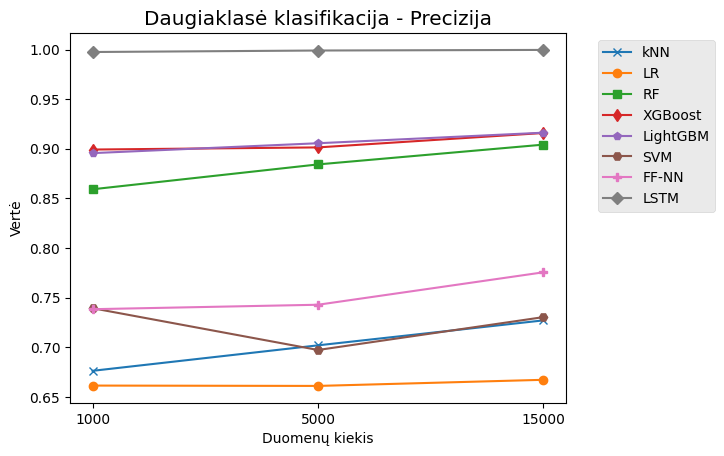

In [8]:
plot_time_series(precision, "Daugiaklasė klasifikacija - Precizija")

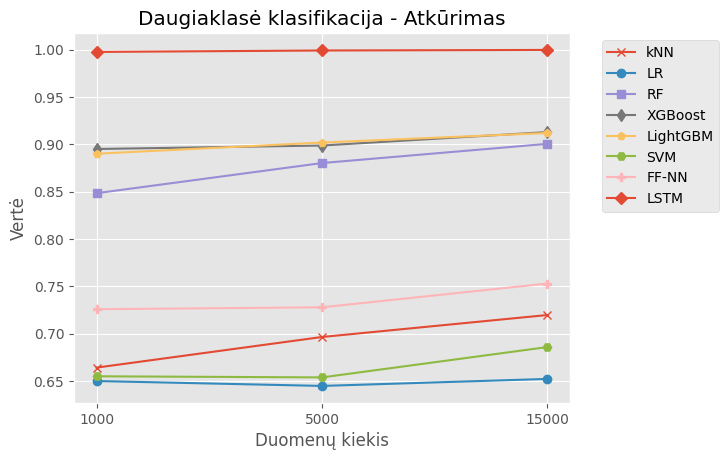

In [9]:
plot_time_series(recall, "Daugiaklasė klasifikacija - Atkūrimas")

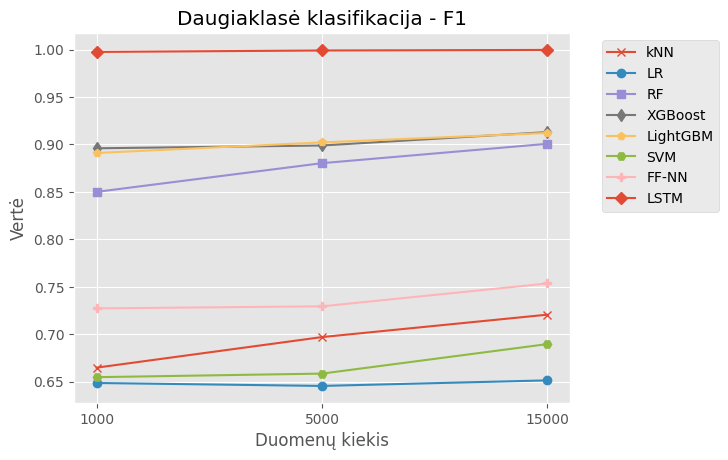

In [10]:
plot_time_series(f1, "Daugiaklasė klasifikacija - F1")

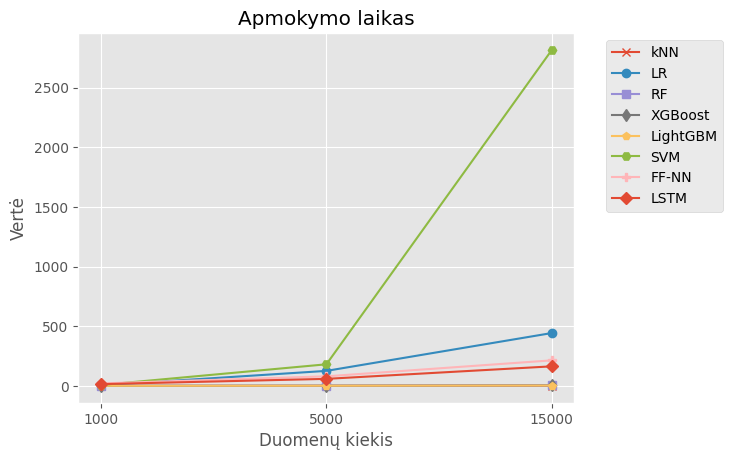

In [11]:
plot_time_series(time, "Apmokymo laikas")

# Results by class

In [148]:
benign_precision, bruteforce_precision, ddos_precision, dos_precision, mirai_precision, recon_precision, spoofing_precision, web_precision = [{} for x in range(8)]

## Precision

In [164]:
new_dict = load_data('results_1000_precision.txt')
precision_1000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_precision['1000'] = precision_1000['Benign']
bruteforce_precision['1000'] = precision_1000['Bruteforce']
ddos_precision['1000'] = precision_1000['DDoS']
dos_precision['1000'] = precision_1000['DoS']
mirai_precision['1000'] = precision_1000['Mirai']
recon_precision['1000'] = precision_1000['Recon']
spoofing_precision['1000'] = precision_1000['Spoofing']
web_precision['1000'] = precision_1000['Web']

In [165]:
new_dict = load_data('results_5000_precision.txt')
precision_5000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_precision['5000'] = precision_5000['Benign']
bruteforce_precision['5000'] = precision_5000['Bruteforce']
ddos_precision['5000'] = precision_5000['DDoS']
dos_precision['5000'] = precision_5000['DoS']
mirai_precision['5000'] = precision_5000['Mirai']
recon_precision['5000'] = precision_5000['Recon']
spoofing_precision['5000'] = precision_5000['Spoofing']
web_precision['5000'] = precision_5000['Web']

## Recall

In [ ]:
benign_precision, bruteforce_precision, ddos_precision, dos_precision, mirai_precision, recon_precision, spoofing_precision, web_precision = [{} for x in range(8)]

In [167]:
new_dict = load_data('results_1000_recall.txt')
recall_1000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_recall['1000'] = recall_1000['Benign']
bruteforce_recall['1000'] = recall_1000['Bruteforce']
ddos_recall['1000'] = recall_1000['DDoS']
dos_recall['1000'] = recall_1000['DoS']
mirai_recall['1000'] = recall_1000['Mirai']
recon_recall['1000'] = recall_1000['Recon']
spoofing_recall['1000'] = recall_1000['Spoofing']
web_recall['1000'] = recall_1000['Web']

NameError: name 'benign_recall' is not defined

In [ ]:
new_dict = load_data('results_5000_recall.txt')
recall_5000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_recall['5000'] = recall_5000['Benign']
bruteforce_recall['5000'] = recall_5000['Bruteforce']
ddos_recall['5000'] = recall_5000['DDoS']
dos_recall['5000'] = recall_5000['DoS']
mirai_recall['5000'] = recall_5000['Mirai']
recon_recall['5000'] = recall_5000['Recon']
spoofing_recall['5000'] = recall_5000['Spoofing']
web_recall['5000'] = recall_5000['Web']

# Plot results by class

## Precision

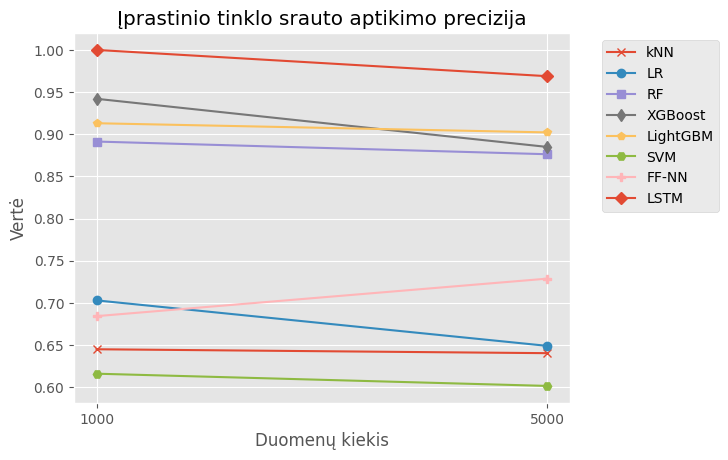

In [153]:
benign_precision = pd.DataFrame(benign_precision).transpose()
plot_time_series(benign_precision, "Įprastinio tinklo srauto aptikimo precizija")

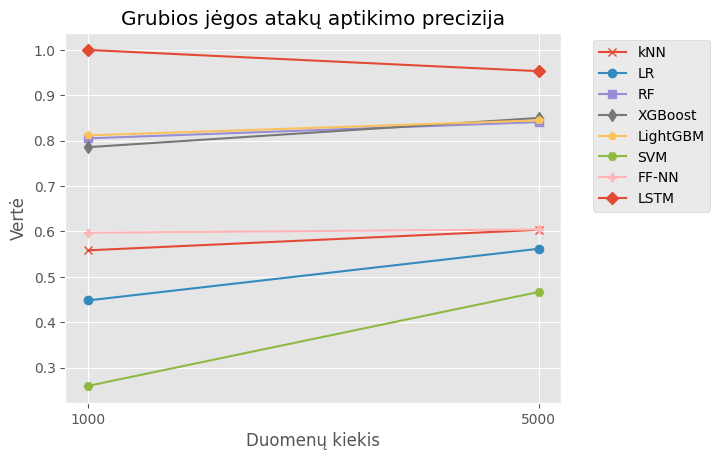

In [154]:
bruteforce_precision = pd.DataFrame(bruteforce_precision).transpose()
plot_time_series(bruteforce_precision, "Grubios jėgos atakų aptikimo precizija")

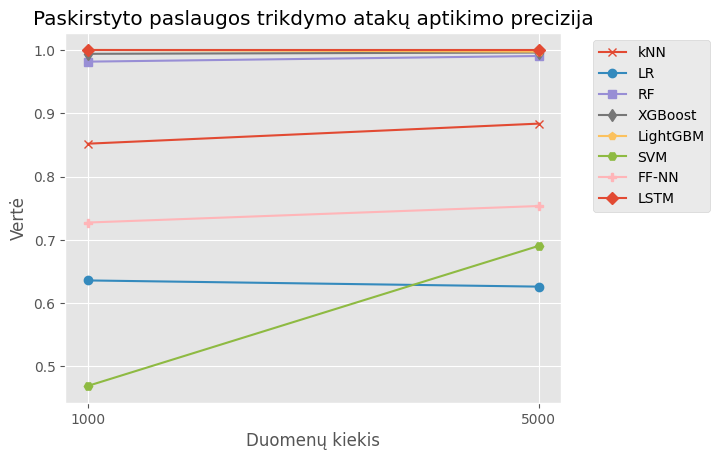

In [155]:
ddos_precision = pd.DataFrame(ddos_precision).transpose()
plot_time_series(ddos_precision, "Paskirstyto paslaugos trikdymo atakų aptikimo precizija")

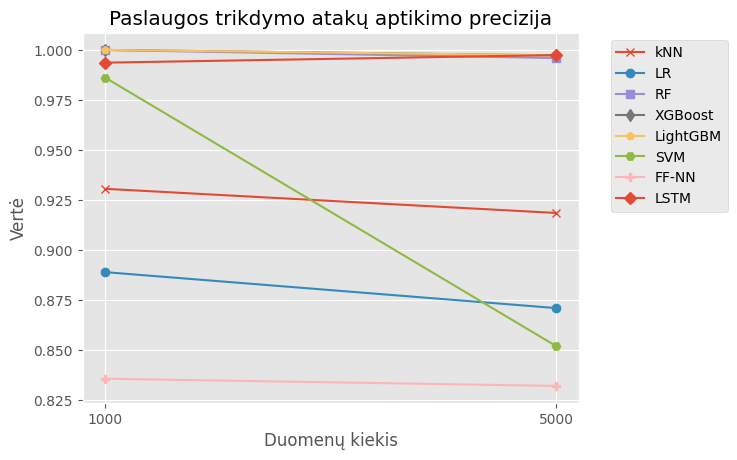

In [156]:
dos_precision = pd.DataFrame(dos_precision).transpose()
plot_time_series(dos_precision, "Paslaugos trikdymo atakų aptikimo precizija")

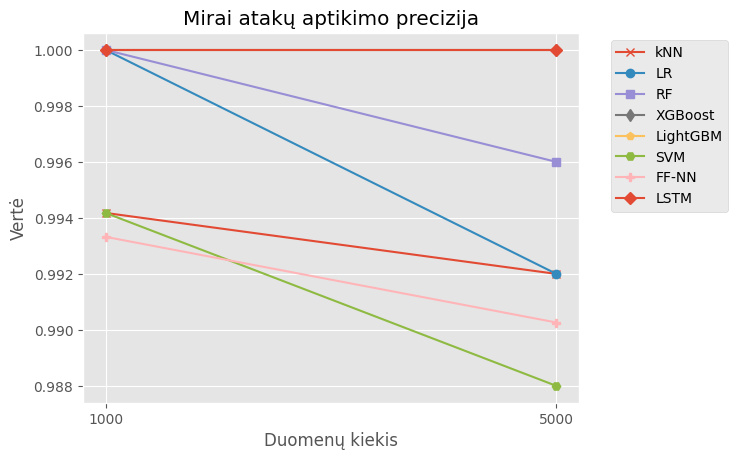

In [157]:
mirai_precision = pd.DataFrame(mirai_precision).transpose()
plot_time_series(mirai_precision, "Mirai atakų aptikimo precizija")

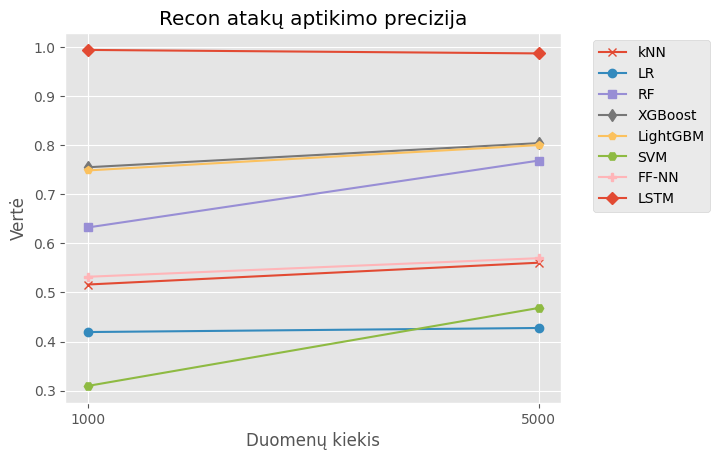

In [158]:
recon_precision = pd.DataFrame(recon_precision).transpose()
plot_time_series(recon_precision, "Recon atakų aptikimo precizija")

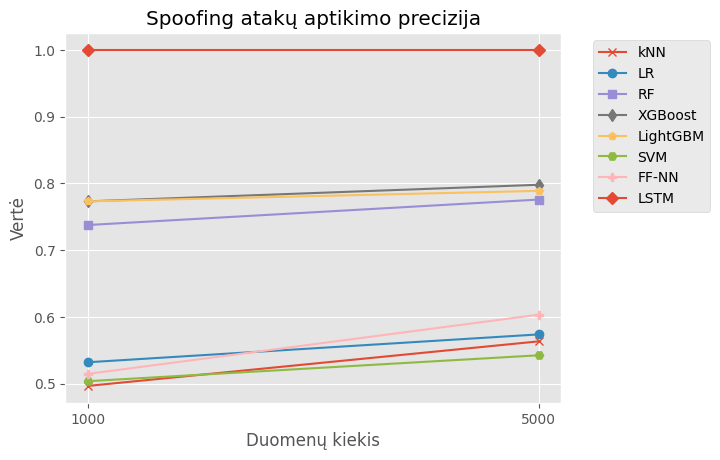

In [159]:
spoofing_precision = pd.DataFrame(spoofing_precision).transpose()
plot_time_series(spoofing_precision, "Spoofing atakų aptikimo precizija")

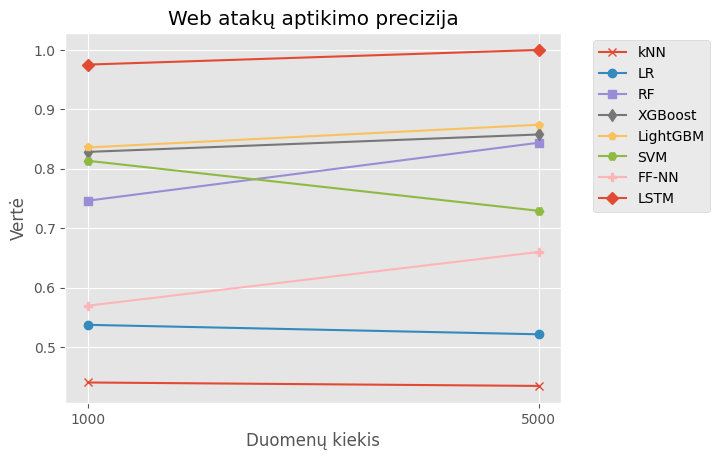

In [160]:
web_precision = pd.DataFrame(web_precision).transpose()
plot_time_series(web_precision, "Web atakų aptikimo precizija")

## Recall

In [ ]:
benign_recall = pd.DataFrame(benign_recall).transpose()
plot_time_series(benign_recall, "Įprastinio tinklo srauto aptikimo atkūrimas")